### Import Packages

In [111]:
import os
import io
import tensorflow as tf
import numpy as np
from azure.storage.blob import BlobServiceClient, ContainerClient
from PIL import Image
import matplotlib.pyplot as plt
import ast


### Connect to Azure

In [83]:
#set up storage
connection_string = "DefaultEndpointsProtocol=https;AccountName=mlfinalexam5505462853;AccountKey=0c40lghglG5/GlNK9yujDQAgo38GKoS2I3DeC/g22hwAEIFANKpmC/TqOpRk4RCT1DbfNiHBFt72+AStB+PfUA==;EndpointSuffix=core.windows.net"
container_name = "publicdata"

#create client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

In [257]:
import numpy as np

# your list of lists
list_of_lists = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

# convert to list of arrays
list_of_arrays = [np.array(lst) for lst in list_of_lists]

# print the list of arrays
for arr in list_of_arrays:
    print(arr)


[1 2 3]
[4 5 6]
[7 8 9]


### Load Image Paths and Labels

In [276]:
#get filepaths
import pandas as pd
df = pd.read_csv("/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/2_Semester/ML/Assignments/machine_learning/ML_Final_Project/preprocessed.csv")

filenames = df["filename"]
# convert each string in the DataFrame to a list
df['Labels'] = df['Labels'].apply(ast.literal_eval)

# convert each list in the DataFrame to a numpy array
df['Labels'] = df['Labels'].apply(np.array)

# store all the arrays in a list
labels = df['Labels'].tolist()

###train,test and validation split

### Set Variables

In [277]:
image_size=224
channels=1

batch_size = 224 # Big enough to measure an F1-score
autotune = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
shuffle_buffer_size = 1024 # Shuffle the training data by a chunck of 1024 observations

### Functions to create data (input for models)

In [280]:
def load_image(path):
    """Load an image from Azure Blob Storage."""
    blob_client = container_client.get_blob_client(path)
    blob_data = blob_client.download_blob().readall()  # Directly read all bytes
    return io.BytesIO(blob_data)

def load_and_preprocess_image(path):
    """Loads an image, decodes it to grayscale, resizes, and normalizes it."""
    # Load image
    image_file = load_image(path.numpy().decode('utf-8'))
    # Decode the image to grayscale
    image_tensor = tf.io.decode_image(image_file.getvalue(), channels=channels)
    # Resize the image
    image_resized = tf.image.resize(image_tensor, [image_size, image_size])
    # Normalize the image data
    image_normalized = image_resized / 255.0
    return image_normalized


def process_tensor(path, label):
    """Function to load an image from blob storage, decode, resize, and normalize it."""
    image_normalized = tf.py_function(load_and_preprocess_image, [path], tf.float32)
    # Ensure the shape is set correctly for grayscale
    image_normalized.set_shape([image_size, image_size, channels])
    return image_normalized, label

def create_dataset(filenames, labels, is_training=True):
    """Creates a TensorFlow dataset from filenames and labels."""
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(process_tensor, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=1024)
        
    dataset = dataset.batch(256)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


### Create the dataset

In [281]:
train_ds = create_dataset(filenames, labels)

### Print the dataset

In [282]:
for images, labels in train_ds.take(1):  # Here, take(1) takes the first batch
    print("Images:", images.numpy())  # Convert tensor to numpy array and print
    print("Labels:", labels.numpy())  # Convert tensor to numpy array and print


2024-05-08 18:28:55.367278: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [50,8]
	 [[{{node Placeholder/_1}}]]
2024-05-08 18:28:55.368070: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [50,8]
	 [[{{node Placeholder/_1}}]]
2024-05-08 18:29:14.889522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 7 of 1024


Images: [[[[0.03953332]
   [0.00586735]
   [0.04024109]
   ...
   [0.038412  ]
   [0.08983903]
   [0.07748326]]

  [[0.03633954]
   [0.01911016]
   [0.03279814]
   ...
   [0.08879147]
   [0.06793321]
   [0.08355603]]

  [[0.01402811]
   [0.02303171]
   [0.00152561]
   ...
   [0.02987915]
   [0.01403531]
   [0.10083536]]

  ...

  [[0.00178558]
   [0.03460765]
   [0.02320642]
   ...
   [0.02880516]
   [0.06903727]
   [0.0318986 ]]

  [[0.01218501]
   [0.04893464]
   [0.02106589]
   ...
   [0.02044046]
   [0.0065597 ]
   [0.02398185]]

  [[0.01754653]
   [0.01225457]
   [0.02100338]
   ...
   [0.04158565]
   [0.01031661]
   [0.07658297]]]


 [[[0.2827931 ]
   [0.28362095]
   [0.29131654]
   ...
   [0.3922496 ]
   [0.3631379 ]
   [0.34895205]]

  [[0.2805172 ]
   [0.2992872 ]
   [0.29530814]
   ...
   [0.3977968 ]
   [0.37155655]
   [0.35699525]]

  [[0.28408113]
   [0.29365999]
   [0.3019608 ]
   ...
   [0.41064453]
   [0.3942927 ]
   [0.3632002 ]]

  ...

  [[0.38129213]
   [0.4142202 ]

2024-05-08 18:29:15.350027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


In [283]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (50, 224, 224, 1)
Shape of labels array: (50, 8)


2024-05-08 18:29:19.681568: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [50,8]
	 [[{{node Placeholder/_1}}]]
2024-05-08 18:29:19.681874: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50]
	 [[{{node Placeholder/_0}}]]


### Plot one image from the dataset

2024-05-08 18:29:25.002867: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50]
	 [[{{node Placeholder/_0}}]]
2024-05-08 18:29:25.003189: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [50,8]
	 [[{{node Placeholder/_1}}]]


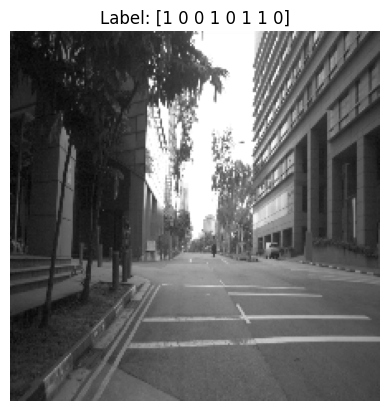

In [284]:
def plot_first_image_from_dataset(dataset, index):
    # Take one batch from the dataset
    for images, labels in dataset.take(index):
        # Assuming the image tensor is in the shape [batch_size, height, width, channels]
        # and you need the first image in the batch
        first_image = images[0]  # This is a tensor

        # Check if the image needs to be squeezed (in case it's a grayscale image with a single channel)
        if first_image.shape[-1] == 1:
            first_image = tf.squeeze(first_image, axis=-1)
        
        # Convert tensor to numpy for plotting
        first_image_np = first_image.numpy()

        # Plot the image
        plt.imshow(first_image_np, cmap='gray')
        plt.title(f'Label: {labels[0].numpy()}')
        plt.axis('off')
        plt.show()

# Example usage with your train_ds dataset
plot_first_image_from_dataset(train_ds,1)

### Self Trained VGG
Source: https://medium.com/@siddheshb008/vgg-net-architecture-explained-71179310050f

In [286]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

import tensorflow as tf

_input = Input((224,224,1)) 

conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(8, activation="sigmoid")(dense2) #adapted number of outputs and outputfunction

vgg16_model  = Model(inputs=_input, outputs=output)

LR = 1e-5
EPOCHS = 10


#compile the model
vgg16_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LR),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

##provide a model summary
#vgg16_model.summary()

#fit the model
vgg16_model.fit(
    train_ds,
    epochs=EPOCHS
)

Epoch 1/10
1/1 [==============================] - 39s 39s/step - loss: 5.5309 - accuracy: 0.1000
Epoch 2/10
1/1 [==============================] - 36s 36s/step - loss: 5.5296 - accuracy: 0.1000
Epoch 3/10
1/1 [==============================] - 36s 36s/step - loss: 5.5282 - accuracy: 0.1000
Epoch 4/10
1/1 [==============================] - 36s 36s/step - loss: 5.5265 - accuracy: 0.1000
Epoch 5/10
1/1 [==============================] - 38s 38s/step - loss: 5.5243 - accuracy: 0.1000
Epoch 6/10
1/1 [==============================] - 40s 40s/step - loss: 5.5215 - accuracy: 0.1000
Epoch 7/10
1/1 [==============================] - 38s 38s/step - loss: 5.5181 - accuracy: 0.1000
Epoch 8/10
1/1 [==============================] - 36s 36s/step - loss: 5.5138 - accuracy: 0.1000
Epoch 9/10
1/1 [==============================] - 36s 36s/step - loss: 5.5083 - accuracy: 0.1000
Epoch 10/10
1/1 [==============================] - 54s 54s/step - loss: 5.5016 - accuracy: 0.1000


In [291]:
predictions = vgg16_model.predict(train_ds)


1/1 [==============================] - 12s 12s/step


In [292]:
predictions

array([[0.5116352 , 0.5043884 , 0.5013455 , 0.5012112 , 0.5061911 ,
        0.51369536, 0.5034517 , 0.4968028 ],
       [0.512818  , 0.5047213 , 0.5013987 , 0.50134265, 0.506809  ,
        0.5152471 , 0.50367886, 0.49646547],
       [0.51407385, 0.5050584 , 0.50163716, 0.50169647, 0.5074896 ,
        0.5166225 , 0.50426924, 0.49600032],
       [0.51316917, 0.5046552 , 0.50147146, 0.5013997 , 0.5067212 ,
        0.51569414, 0.503906  , 0.49635273],
       [0.5128649 , 0.50488615, 0.50153625, 0.5014889 , 0.50674486,
        0.51518387, 0.50389045, 0.49628085],
       [0.51363736, 0.50492716, 0.5015412 , 0.50145966, 0.5072394 ,
        0.51619303, 0.50427544, 0.4960592 ],
       [0.5127513 , 0.5046778 , 0.50155175, 0.50136214, 0.50654703,
        0.5151401 , 0.50385034, 0.49637955],
       [0.5130584 , 0.50485116, 0.5014668 , 0.5013799 , 0.50674635,
        0.5154678 , 0.5037742 , 0.49634957],
       [0.5112357 , 0.504122  , 0.5012625 , 0.5010853 , 0.50587195,
        0.5133102 , 0.503413

### Pre Trained VGG
Source: https://medium.com/@siddheshb008/vgg-net-architecture-explained-71179310050f

In [ ]:

from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt 
from PIL import Image 
import seaborn as sns
import pandas as pd 
import numpy as np 
import os 

img1 = "../input/flowers-recognition/flowers/tulip/10094729603_eeca3f2cb6.jpg"
img2 = "../input/flowers-recognition/flowers/dandelion/10477378514_9ffbcec4cf_m.jpg"
img3 = "../input/flowers-recognition/flowers/sunflower/10386540696_0a95ee53a8_n.jpg"
img4 = "../input/flowers-recognition/flowers/rose/10090824183_d02c613f10_m.jpg"
imgs = [img1, img2, img3, img4]

def _load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img 

def _get_predictions(_model):
    f, ax = plt.subplots(1, 4)
    f.set_size_inches(80, 40)
    for i in range(4):
        ax[i].imshow(Image.open(imgs[i]).resize((200, 200), Image.ANTIALIAS))
    plt.show()
    
    f, axes = plt.subplots(1, 4)
    f.set_size_inches(80, 20)
    for i,img_path in enumerate(imgs):
        img = _load_image(img_path)
        preds  = decode_predictions(_model.predict(img), top=3)[0]
        b = sns.barplot(y=[c[1] for c in preds], x=[c[2] for c in preds], color="gray", ax=axes[i])
        b.tick_params(labelsize=55)
        f.tight_layout()

### Pre Trained Weights

In [ ]:

from keras.applications.vgg16 import VGG16
vgg16_weights = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
vgg16_model = VGG16(weights=vgg16_weights)
_get_predictions(vgg16_model)

'''
Downloading data from https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json
40960/35363 [==================================] - 0s 0us/step
'''


https://medium.com/geekculture/boost-your-image-classification-model-with-pretrained-vgg-16-ec185f763104

In [2]:
class RockPaperScissorsVgg16:
    def __init__(self, input_width, input_height):
        self.input_shape = (input_width, input_height, 3)
        self.classes = 3
        self.model = None
        self.build_model()

    def build_model(self):
        vgg16 = VGG16(weights='imagenet', input_shape=self.input_shape, classes=self.classes, include_top=False)

        for layer in vgg16.layers:
            layer.trainable = False

        x = Flatten()(vgg16.output)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.classes, activation='softmax')(x)

        self.model = Model(inputs=vgg16.input, outputs=predictions)
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def train_vgg16(train_images, train_labels) -> Model:
        vgg16 = RockPaperScissorsVgg16(INPUT_WIDTH, INPUT_HEIGHT)
        model = vgg16.model
        model.summary()

        train_generator, validation_generator = get_generators(train_images, train_labels)

        model.fit(
            train_generator,
            steps_per_epoch=40,
            epochs=50,
            validation_data=validation_generator,
            validation_steps=10,
            callbacks=[StopByAccuracyCallback()]
        )

        return model

In [1]:
import pandas as pd
df = pd.read_csv("/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/2_Semester/ML/Assignments/machine_learning/ML_Final_Project/preprocessed.csv")

In [2]:
df

,Unnamed: 0,filename,Human,Barrier,Bike,Motorcycle,Truck,Car,Trafficcone,NoDetec,Labels,image
0,0,samples/CAM_BACK/n003-2018-01-03-12-03-23+0800...,1,0,0,1,1,1,0,0,"[1, 0, 0, 1, 1, 1, 0, 0]",[[0.28235294 0.30196078 0.30196078 ... 0.70588...
1,1,samples/CAM_BACK/n003-2018-01-08-11-30-34+0800...,1,1,0,1,1,1,0,0,"[1, 1, 0, 1, 1, 1, 0, 0]",[[0.21960784 0.22745098 0.23921569 ... 0.36078...
2,2,samples/CAM_BACK/n003-2018-07-12-15-40-35+0800...,1,0,0,1,0,1,0,0,"[1, 0, 0, 1, 0, 1, 0, 0]",[[0.46666667 0.4627451 0.4627451 ... 0.75686...
3,3,samples/CAM_BACK/n005-2018-06-14-20-11-03+0800...,0,0,0,0,0,1,0,0,"[0, 0, 0, 0, 0, 1, 0, 0]",[[0.06666667 0.04705882 0.05882353 ... 0.08627...
4,4,samples/CAM_BACK/n008-2018-06-04-16-30-00-0400...,0,0,0,0,1,1,0,0,"[0, 0, 0, 0, 1, 1, 0, 0]",[[0.38039216 0.37254902 0.33333333 ... 0.35686...
5,5,samples/CAM_BACK/n009-2018-05-08-15-52-41-0400...,0,0,1,0,1,1,0,0,"[0, 0, 1, 0, 1, 1, 0, 0]",[[0.3372549 0.33333333 0.31372549 ... 0.66274...
6,6,samples/CAM_BACK/n010-2018-08-27-12-00-23+0800...,1,1,0,0,1,1,0,0,"[1, 1, 0, 0, 1, 1, 0, 0]",[[0.19215686 0.22352941 0.22745098 ... 0.29411...
7,7,samples/CAM_BACK/n013-2018-08-20-14-38-24+0800...,0,0,1,0,1,1,0,0,"[0, 0, 1, 0, 1, 1, 0, 0]",[[0.22352941 0.25490196 0.22745098 ... 0.18431...
8,8,samples/CAM_BACK/n013-2018-08-21-11-46-25+0800...,1,0,0,0,0,1,0,0,"[1, 0, 0, 0, 0, 1, 0, 0]",[[0.44313725 0.50196078 0.49803922 ... 0.36470...
9,9,samples/CAM_BACK/n013-2018-08-28-16-04-27+0800...,1,0,0,0,0,1,0,0,"[1, 0, 0, 0, 0, 1, 0, 0]",[[0.15686275 0.18431373 0.17254902 ... 0.25490...


In [5]:
image = df.image[1]
type(image)

str